In [1]:
import pandas as pd
import numpy as np
import time as t
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix


In [2]:
# For loading dataset....
print("Loading Data")
DATASET_PATH = r'C:\Users\HP\malicious_url_detector\data\urls.csv' 
try:
    url_df = pd.read_csv(DATASET_PATH)
    url_df = url_df[['url', 'label']].dropna().reset_index(drop=True)
    print("Dataset loaded successfully.....")
    
except (FileNotFoundError, ValueError) as issue:
    print("Issue in loading data")
    data = {
        'url': ['google.com', 'facebook.com', 'secure-paypa-l.com/update', 'bankofame-rica.net/login', 'malware-site.xyz/download.exe', 'http://tny.url/phish456'],
        'label': ['benign', 'benign', 'phishing', 'phishing', 'malware', 'defacement']
    }
    ur_df = pd.DataFrame(data)


Loading Data
Dataset loaded successfully.....


In [3]:
url_df['label_1'] = url_df['label'].str.strip().str.lower()
# Assigning values for safe and unsafe because text cannot read in machine learning modals 
mapping = {
    'Safe':1,
    'Unsafe':0
}
url_df['label_1']= url_df['label'].replace(mapping)
#checking for unmapped sample 
unmapped= url_df['label_1'].isna().sum()
if unmapped>0:
    print("labels are mismatching")
else:
    print("Labels matched perfectly")

Labels matched perfectly


In [4]:
#checking the distribution of both classess
if 0 not in url_df['label_1'].unique() or 1 not in url_df['label_1'].unique():
    print("Error") 

In [5]:
#for displaying
names=['Safe(1)', 'Unsafe(0)']
labels=[0,1]

In [6]:
#final label used for machine learning
m=url_df['label_1']
print(f"Total sample: {len(url_df)}") # f-string make python to treat as live veriable under {}
print(url_df[['url','label','label_1']].head()) #dispplay first 5 rows
print(f"Distribution of classes:\n{url_df['label_1'].value_counts()}") #Displaying the classes and count of each class
print(f"names:{names}") #Shows which number belong to which label i.e safe and unsafe
print("labels are ready......")

Total sample: 49750
                                                 url   label  label_1
0                                   br-icloud.com.br  Unsafe        0
1                mp3raid.com/music/krizz_kaliko.html    Safe        1
2                    bopsecrets.org/rexroth/cr/1.htm    Safe        1
3  http://www.garage-pirenne.be/index.php?option=...  Unsafe        0
4  http://adventure-nicaragua.net/index.php?optio...  Unsafe        0
Distribution of classes:
1    36419
0    13331
Name: label_1, dtype: int64
names:['Safe(1)', 'Unsafe(0)']
labels are ready......


In [7]:
print("Starting feature engineering")
#lexical features 
def url_len(url): return len(url) #toal number of characters 
def num_dots(url) : return url.count('.') #count every dots
def has_shortened(url):
    short_services=[
        'bit.do','tny.url','bit.ly','is.gd','buff.ly','t.co'
    ]
    return 1 if any(service in url for service in short_services) else 0 #checks urls which provide short services
def number_special_characters(url):
    return len(re.findall(r'[^a-zA-Z0-9.\/]',url))
print("lexical features done")

Starting feature engineering
lexical features done


In [8]:
# Feature extraction
url_df['url_len'] =url_df['url'].apply(url_len)
url_df['number_dots']= url_df['url'].apply(num_dots)
url_df['has_shortened']=url_df['url'].apply(has_shortened)
url_df['num_special']=url_df['url'].apply(number_special_characters)
lexical_features_columns=['url_len','number_dots','has_shortened','num_special']
print("Successfully Features extracted")

Successfully Features extracted


In [9]:
# TF-IDF features (content-based features)
vect_tfidf = TfidfVectorizer(max_features=100, token_pattern=r'[a-zA-Z0-9]+') #scan urls and identfies top 100 frequent words or tokens (patterns), also ignore symbols  
features_tfidf = vect_tfidf.fit_transform(url_df['url']).toarray() #covert each url to 100 numbers 
tfidf_url_df = pd.DataFrame(features_tfidf, columns=[f'tfidf_{i}' for i in range(features_tfidf.shape[1])]) #keep a table that contains those 100 numbers per url
print("content-based features are ready...")

content-based features are ready...


In [10]:
#Define features names
names_features_li=lexical_features_columns +[f'tfidf_{j}' for j in range(features_tfidf.shape[1])] #1 represents rows
#combine features
n_lexical_features=url_df[lexical_features_columns]
n=pd.concat([n_lexical_features,tfidf_url_df], axis=1)
print("All Features are comibned")
print(f"The Total Features are Generated:{n.shape[1]}")

All Features are comibned
The Total Features are Generated:104


In [11]:
print("Few example of features are:") #display features 
print(n_lexical_features.head())# top 5 features displays

Few example of features are:
   url_len  number_dots  has_shortened  num_special
0       16            2              0            1
1       35            2              0            1
2       31            2              0            0
3       88            3              0           12
4      200            2              0            9


In [12]:
#Spliting data and processing
n_full_train, n_full_test, m_train, m_test=train_test_split(n,m,test_size=0.2, random_state=42, stratify=m)
#test size= 20%, random_state make sures saffle same everytime, stratify sets balance data for both testing and training
print(m_train.value_counts(normalize=True))
print(m_test.value_counts(normalize=True))
print(f"Total rows in dataset: {len(n)}") #Total dataset contains number of samples  
#display how many sample used for testing and training
print(f"Training set rows: {n_full_train.shape[0]}")
print(f"Testing set rows: {n_full_test.shape[0]}")

1    0.732035
0    0.267965
Name: label_1, dtype: float64
1    0.73206
0    0.26794
Name: label_1, dtype: float64
Total rows in dataset: 49750
Training set rows: 39800
Testing set rows: 9950


In [13]:
#Feature isolation
lexical_features_cols=n_lexical_features.columns
tfidf_features_cols=tfidf_url_df.columns


In [14]:
#big tables of training and testing is divided into four small tables 
n_lexi_train=n_full_train[lexical_features_cols]
n_lexi_test=n_full_test[lexical_features_cols]
n_tfidf_train=n_full_train[tfidf_features_cols]
n_tfidf_test=n_full_test[tfidf_features_cols]


In [15]:
print("Successfully completed the Isolation..")

Successfully completed the Isolation..


In [16]:
print(f"Lexical features:{n_lexi_train.shape[1]}")
print(f"TF-IDF features:{n_tfidf_train.shape[1]}")

Lexical features:4
TF-IDF features:100


In [17]:
#scaling lexical features 
scale=StandardScaler()
n_scale_train_lexi_features=scale.fit_transform(n_lexi_train)
n_scale_test_lexi_features=scale.fit_transform(n_lexi_test)

In [18]:
n_scaled_train=np.hstack((n_scale_train_lexi_features,n_tfidf_train.values))
n_scaled_test=np.hstack((n_scale_test_lexi_features,n_tfidf_test.values))

In [19]:
#training data for Multi naive bayes
n_mnb_data_train=n_full_train.values
n_mnb_data_test=n_full_test.values

In [21]:
print(f"Final training samples:{len(n_full_train)}.")
print(f"Final testing samples:{len(n_full_test)}.")

Final training samples:39800.
Final testing samples:9950.


In [22]:
#training and testing modals
models={
    #three mdoals used : MNB,SVM,RF
    'Multinomial Naive Bayes (MNB)': {
        'model': MultinomialNB(), 'n_train_model': n_mnb_data_train, 'n_test_model': n_mnb_data_test},
    'Support Vector Machine (SVM)': {
        'model': SVC(kernel='linear', random_state=42), 'n_train_model': n_scaled_train, 'n_test_model': n_scaled_test},
    'Random Forest (RF)': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42), 'n_train_model': n_scaled_train, 'n_test_model': n_scaled_test}
}
 
result={} #creating empty dictonary to hold output
print("Sucessfully created dictory for each modal")
for name,parameters in models.items():
    present_model=parameters['model']
    n_train_model=parameters['n_train_model']
    n_test_model=parameters['n_test_model']
    
    #training
    print(f"training the modal {name}")
    begin=t.time()
    present_model.fit(n_train_model,m_train)
    time_of_training=t.time() - begin
    #For testing 
    pred=present_model.predict(n_test_model)
    acc=accuracy_score(m_test,pred)
    score_f1=f1_score(m_test,pred,average='weighted')
    print(f"Results {name}")
    print(f"accuracy {acc}")
    #transforimg text report into proper python dictionary and used for comparsions 
    report_model= classification_report(
        m_test,
        pred,
        target_names=['Unsafe(0)', 'Safe(1)'],
        labels=labels,
        output_dict=True, 
        zero_division=0)
    
    #Add confusion matrix which is most important in cyber security
    conf_matrix=confusion_matrix(m_test, pred) 
    result[name] = {
      'Accuracy':acc,
      'F1-Score':score_f1,
      'Precision':report_model['weighted avg']['precision'],
      'Recall':report_model['weighted avg']['recall'],
      'Training Time of Model':time_of_training,
      'Confusion Matrix':conf_matrix,
      'Classification of Report':report_model}
    
    #interpretability of model
    try:
        if name=='Random Forest (RF)':
            importances_rf=present_model.feature_importances_
            rf_importances_report=pd.Series(importances_rf,index=names_features_li[:n_train_model.shape[1]]).sort_values(ascending=False)
            result[name]['Importance_Features']=rf_importances_report
            result[name]['model_object']=present_model
    except exception as e:
        print(e)
        
    print(f"Model: {name} completed.")
    print(f"Accuracy: {acc:.4f} | F1-Score (Weighted): {score_f1:.4f}")
    print(f"Training Time of Model: {time_of_training:.4f}s")
    # Print the full report using the original class names
    print("Full Classification Report:")
    print(classification_report(m_test, pred, target_names=['Unsafe(0)', 'Safe(1)'], labels=labels, zero_division=0))

Sucessfully created dictory for each modal
training the modal Multinomial Naive Bayes (MNB)
Results Multinomial Naive Bayes (MNB)
accuracy 0.8851256281407035
Model: Multinomial Naive Bayes (MNB) completed.
Accuracy: 0.8851 | F1-Score (Weighted): 0.8822
Training Time of Model: 0.0272s
Full Classification Report:
              precision    recall  f1-score   support

   Unsafe(0)       0.83      0.72      0.77      2666
     Safe(1)       0.90      0.95      0.92      7284

    accuracy                           0.89      9950
   macro avg       0.87      0.83      0.85      9950
weighted avg       0.88      0.89      0.88      9950

training the modal Support Vector Machine (SVM)
Results Support Vector Machine (SVM)
accuracy 0.9326633165829146
Model: Support Vector Machine (SVM) completed.
Accuracy: 0.9327 | F1-Score (Weighted): 0.9308
Training Time of Model: 50.7721s
Full Classification Report:
              precision    recall  f1-score   support

   Unsafe(0)       0.94      0.80    

In [23]:
print("\n---Overall Comparative Analysis Results of all Models--")
#creating new DataFrame and Transpose which make the raw data to structural report 
comparative_results_df=pd.DataFrame(result).T 
metrics_used=['Accuracy','F1-Score','Precision','Recall','Training Time of Model']
print("\n---Summary of Comparative Analysis")
#Final Overview of Table for analysis
print(comparative_results_df[metrics_used].sort_values(by='F1-Score',ascending=False).to_markdown(floatfmt=".4f")) #shows 4 digits only



---Overall Comparative Analysis Results of all Models--

---Summary of Comparative Analysis
|                               |   Accuracy |   F1-Score |   Precision |   Recall |   Training Time of Model |
|:------------------------------|-----------:|-----------:|------------:|---------:|-------------------------:|
| Random Forest (RF)            |     0.9623 |     0.9617 |      0.9627 |   0.9623 |                   6.8032 |
| Support Vector Machine (SVM)  |     0.9327 |     0.9308 |      0.9331 |   0.9327 |                  50.7721 |
| Multinomial Naive Bayes (MNB) |     0.8851 |     0.8822 |      0.8825 |   0.8851 |                   0.0272 |


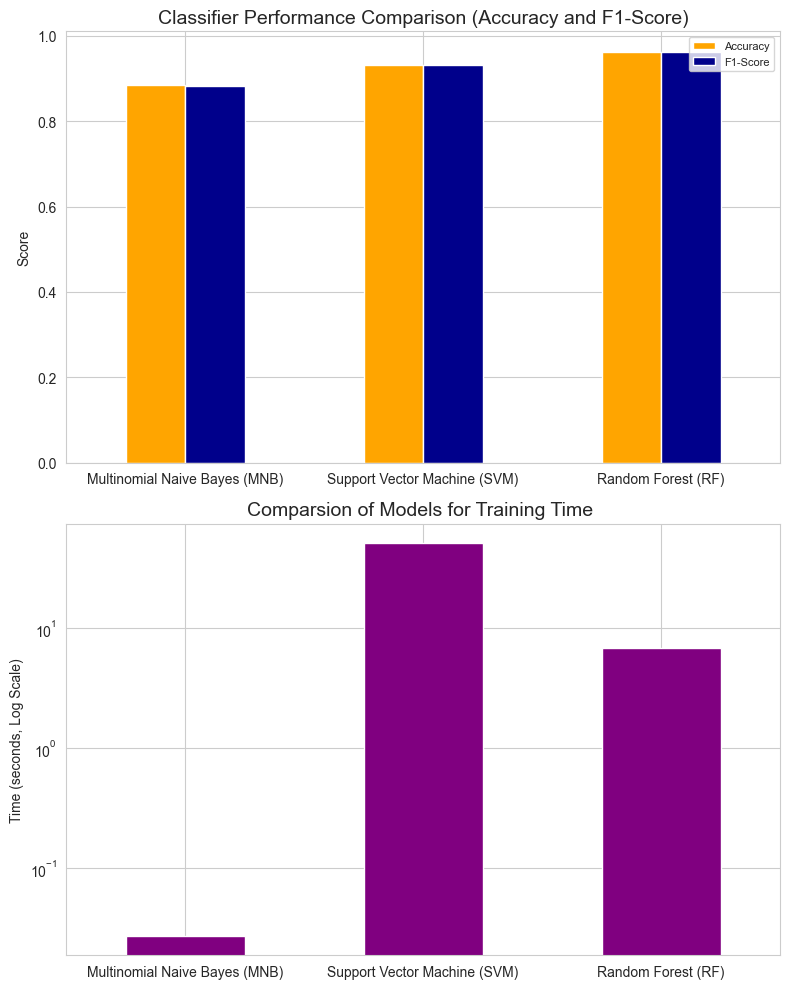

In [24]:
#Visualization 
#Perfomance comparsion of modals interns of accuracy and F1-Score
sns.set_style("whitegrid")
plt.figure(figsize=(8, 10))
#t6576
plt.subplot(2,1,1,)
comparative_results_df[['Accuracy', 'F1-Score']].plot(kind='bar', ax=plt.gca(), legend=True, 
                                                     color=['orange', 'darkblue'])
plt.title('Classifier Performance Comparison (Accuracy and F1-Score)',fontsize=14)
plt.ylabel('Score',fontsize=10)
plt.xticks(rotation=0, ha='center')
plt.legend(loc='upper right',fontsize=8)

#display the comparsion of modals for training time data inerms of seconds
plt.subplot(2,1,2)
comparative_results_df['Training Time of Model'].plot(kind='bar', color='purple', ax=plt.gca())
plt.title('Comparsion of Models for Training Time ',fontsize=14)
plt.ylabel('Time (seconds, Log Scale)',fontsize=10)
plt.yscale('log') 
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.tight_layout()
plt.show()





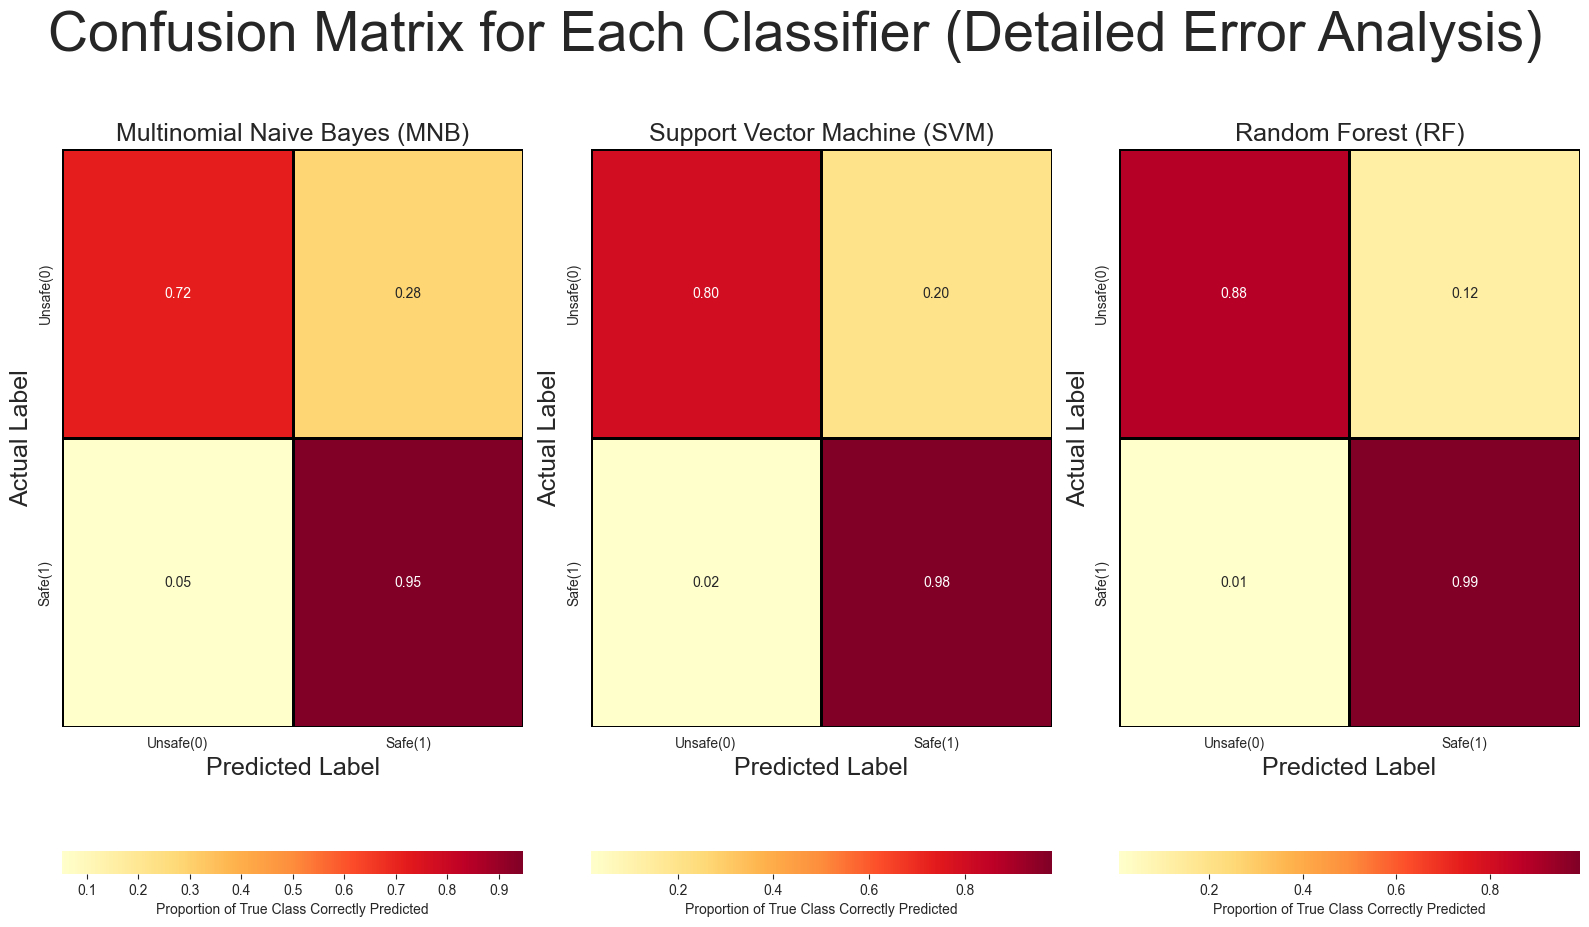

In [25]:
#We use confusion matrix heatmaps which is important than the accuracy in cybersecurity 
fig, axes = plt.subplots(1, 3, figsize=(16, 10))
fig.suptitle('Confusion Matrix for Each Classifier (Detailed Error Analysis)', fontsize=40)

for i, name in enumerate(models.keys()):
    cm = result[name]['Confusion Matrix']
    # Normalize the matrix to show percentages instead of raw counts for better comparison
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd', 
                linewidths=2, linecolor='black',
                xticklabels=['Unsafe(0)', 'Safe(1)'], yticklabels=['Unsafe(0)', 'Safe(1)'], ax=axes[i],
                cbar_kws={'label': 'Proportion of True Class Correctly Predicted', 'orientation':'horizontal'})
    axes[i].set_title(f"{name}", fontsize=18)
    axes[i].set_ylabel('Actual Label', fontsize=18)
    axes[i].set_xlabel('Predicted Label',fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



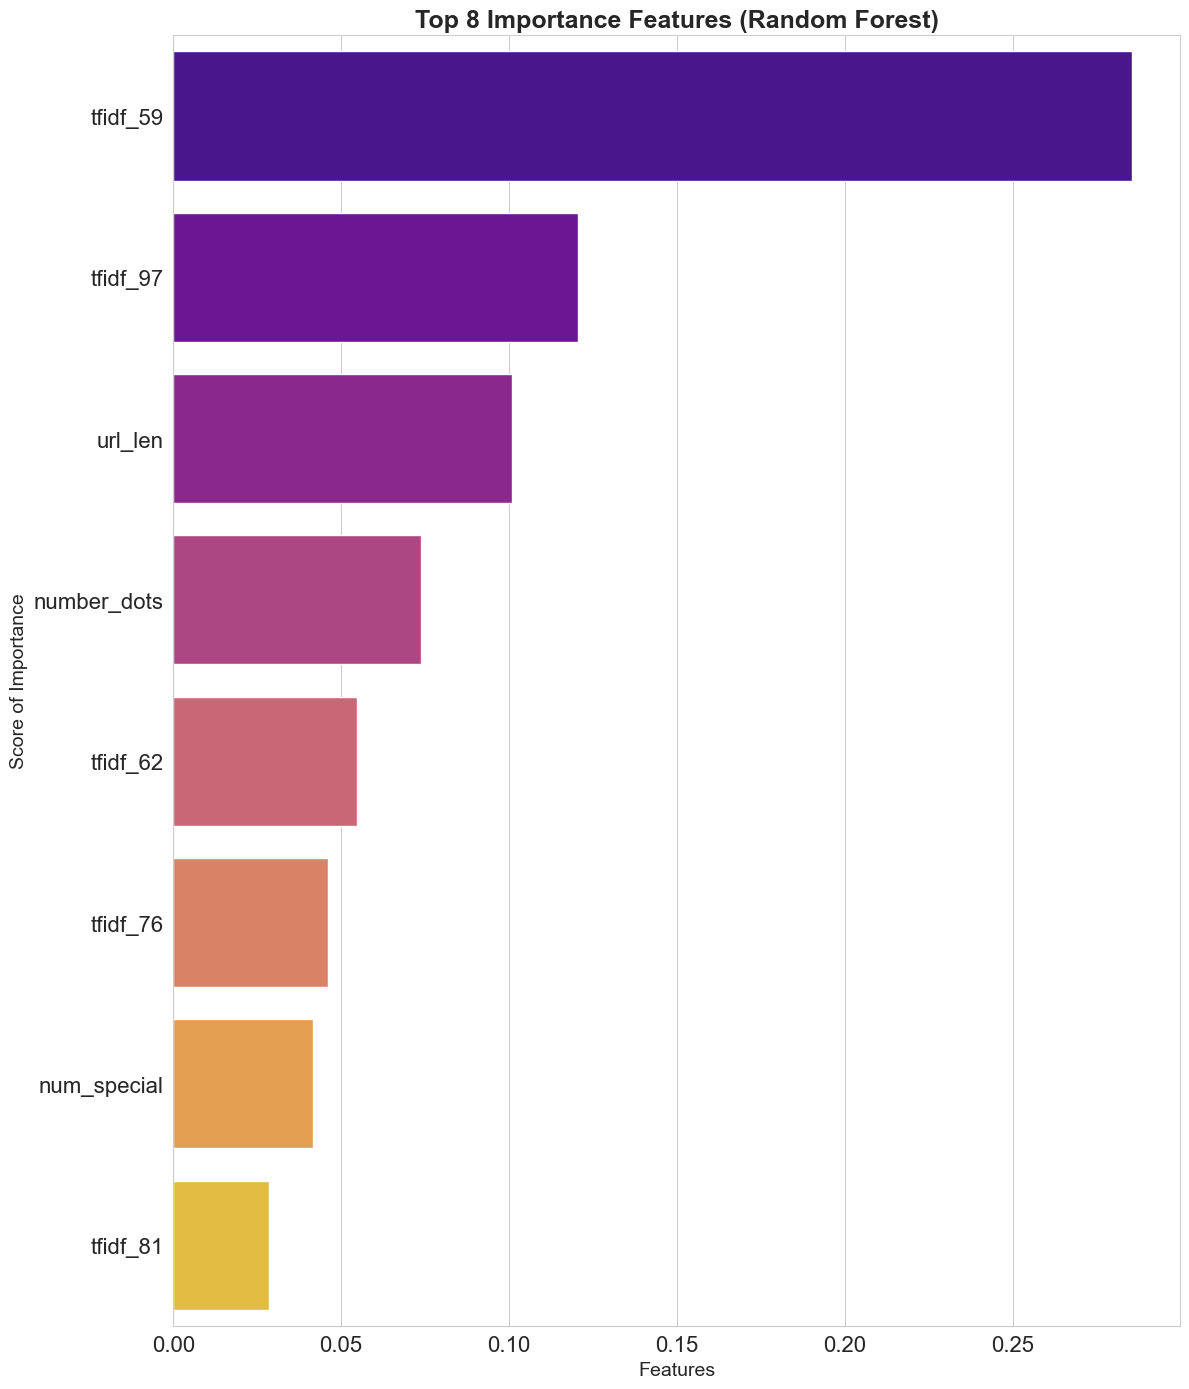

In [26]:
#This reveals the feature importance behind Random Forest decision 

if 'Random Forest (RF)' in result and 'Importance_Features' in result['Random Forest (RF)']:
    importance_rf=result['Random Forest (RF)'][ 'Importance_Features']. head(8)
    
    plt.figure(figsize=(12,14))
    sns.barplot(x=importance_rf.values, y=importance_rf.index, palette='plasma')
    # This specifically targets the text labels on the axes
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title('Top 8 Importance Features (Random Forest)', fontsize=18, fontweight='bold')
    plt.ylabel('Score of Importance', fontsize=14)
    plt.xlabel('Features', fontsize=14)
    plt.tight_layout()
    plt.show